In [136]:
import pandas as pd
import scipy as sc
import numpy as np
import os


import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import colorConverter
import seaborn as sns

%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


Project-level imports.

In [137]:
from constants import guest_types
from constants import colors
from bootstrap import bootstrap
from bootstrap import dG_bootstrap
import plotting

# Load in results

In [138]:
bgbg = pd.read_csv("results/bgbg_tip3p_by_orientation.csv")
bgbg_combined = pd.read_csv("results/bgbg_tip3p_combined.csv")

bg2bg2 = pd.read_csv("results/bg2bg2_tip3p_by_orientation.csv")
bg2bg2_combined = pd.read_csv("results/bg2bg2_tip3p_combined.csv")

smirnoff = pd.read_csv("results/smirnoff_by_orientation.csv")
smirnoff_combined = pd.read_csv("results/smirnoff_combined.csv")

experimental = pd.read_csv("results/experimental.csv")

# Plot comparisons

In [153]:
def scatter(df, x, y, xerr, yerr, xlabel, ylabel, colors, name, statistics_file_prefix):
    fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))

    for index, typ in enumerate(df["Type"].unique()):
        tmp = df[df["Type"] == typ]        
        ax.errorbar(
            tmp[x],
            tmp[y],
            xerr=tmp[xerr],
            yerr=tmp[yerr],
            fmt="o",
            markersize=8,
            markeredgecolor="k",
            markeredgewidth=0.2,
            elinewidth=1.0,
            ecolor="0.5",
            color=colors[typ],
        )

        type_statistics = pd.read_csv(f"results/{statistics_file_prefix}_{typ}.csv")
        type_statistics.index = type_statistics["Unnamed: 0"]
        type_string = f"R$^2$ = {type_statistics['mean']['R**2']:0.2f}"
        artist = ax.annotate(
            type_string,
            (0.98, 0.02 + 0.05 * index),
            xytext=(4, -4),
            xycoords="axes fraction",
            textcoords="offset points",
            horizontalalignment="right",
            verticalalignment="bottom",
            size=14,
            color=colors[typ],
            transform=ax.transAxes,
        )

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.plot([-50, 50], [-50, 50], ls="-", c="0.3", zorder=-1, lw="0.5")
    ax.set_ylim(-8, 2)
    ax.set_xlim(-8, 2)

    statistics = pd.read_csv(f"results/{statistics_file_prefix}_overall.csv")
    statistics.index = statistics["Unnamed: 0"]
    
    text = f"RMSE = {statistics['mean']['RMSE']:0.2f} [{statistics['mean']['RMSE']-1.96*statistics['sem']['RMSE']:0.2f}, {statistics['mean']['RMSE']+1.96*statistics['sem']['RMSE']:0.2f}]"
    text += "\n"
    text += f"R$^2$ = {statistics['mean']['R**2']:0.2f} [{statistics['mean']['R**2']-1.96*statistics['sem']['R**2']:0.2f}, {statistics['mean']['R**2']+1.96*statistics['sem']['R**2']:0.2f}]"
    left, width = .25, .5
    bottom, height = .25, .5
    right = left + width
    top = bottom + height
    ax.annotate(
        text,
        (0.01, 0.99),
        xytext=(4, -4),
        xycoords="axes fraction",
        textcoords="offset points",
        horizontalalignment="left",
        verticalalignment="top",
        size=14,
        backgroundcolor="white",
        transform=ax.transAxes,
    )
    fig.savefig(f"figures/{name}.pdf", bbox_inches="tight")
    fig.savefig(f"figures/{name}.svg", bbox_inches="tight")

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (56) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (54) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (52) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (79) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (57) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (57) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (71) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (40) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (107) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/ma

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (93) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (51) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))


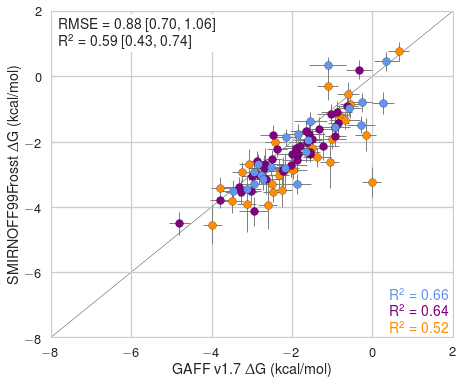

In [154]:
# SMIRNOFF99Frosst vs. GAFF v1.7

df = smirnoff.merge(bgbg, on=["System", "Type"], suffixes=("_smirnoff",
                                                                "_bgbg_tip3p"))
assert(len(df) == 86)

artist = scatter(df, 
        x="Delta G_bgbg_tip3p",
        y="Delta G_smirnoff",
        xerr="G_SEM_bgbg_tip3p",
        yerr="G_SEM_smirnoff",
        xlabel=r"GAFF v1.7 $\Delta$G (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$G (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-GAFF-v1.7-dG-by-orientation",
        statistics_file_prefix="bgbg_smirnoff_by_orientation_dG_statistics")

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (56) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (54) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (52) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (57) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (114) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (115) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/m

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (108) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (47) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (109) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/m

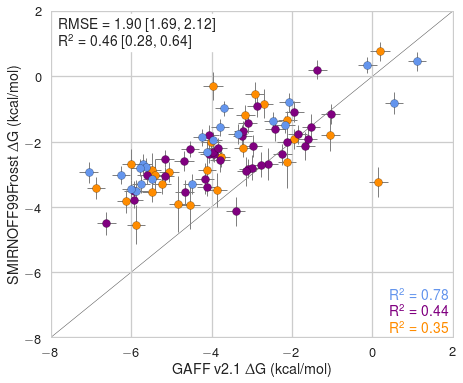

In [155]:
# SMIRNOFF99Frosst vs. GAFF v2.1

df = smirnoff.merge(bg2bg2, on=["System", "Type"], suffixes=("_smirnoff",
                                                                "_bg2bg2_tip3p"))
assert(len(df) == 86)

scatter(df, 
        x="Delta G_bg2bg2_tip3p",
        y="Delta G_smirnoff",
        xerr="G_SEM_bg2bg2_tip3p",
        yerr="G_SEM_smirnoff",
        xlabel=r"GAFF v2.1 $\Delta$G (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$G (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-GAFF-v2.1-dG-by-orientation",
        statistics_file_prefix="bg2bg2_smirnoff_by_orientation_dG_statistics")

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (56) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (54) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (52) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (77) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (83) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (69) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (109) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (111) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (108) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/

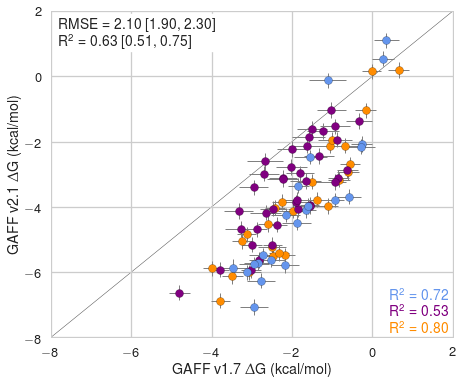

In [156]:
# GAFF v1.7 vs. GAFF v2.1

df = bgbg_tip3p.merge(bg2bg2_tip3p, on=["System", "Type"], suffixes=("_bgbg_tip3p",
                                                                "_bg2bg2_tip3p"))
assert(len(df) == 86)

scatter(df, 
        x="Delta G_bgbg_tip3p",
        y="Delta G_bg2bg2_tip3p",
        xerr="SEM_bgbg_tip3p",
        yerr="SEM_bg2bg2_tip3p",
        xlabel=r"GAFF v1.7 $\Delta$G (kcal/mol)",
        ylabel=r"GAFF v2.1 $\Delta$G (kcal/mol)",
        colors=colors,
        name="GAFF-v2.1-vs-GAFF-v1.7-dG-by-orientation",
        statistics_file_prefix="bgbg_bg2bg2_by_orientation_dG_statistics")

## Combined results with pre-computed statistics

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (56) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (54) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (52) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (83) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (77) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (73) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (50) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (48) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (69) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (82) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (78) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (79) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

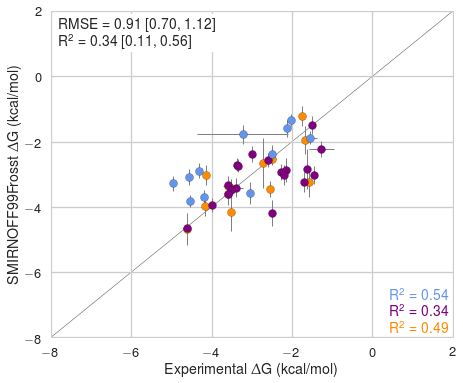

In [163]:
# SMIRNOFF99Frosst vs. Experiment

df = smirnoff_combined.merge(experimental, on=["System"], suffixes=("_smirnoff",
                                                                "_experiment"))
assert(len(df) == 43)

scatter(df, 
        x="Delta G_experiment",
        y="Delta G_smirnoff",
        xerr="G_SEM_experiment",
        yerr="G_SEM_smirnoff",
        xlabel=r"Experimental $\Delta$G (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$G (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-Experiment-dG",
        statistics_file_prefix="experimental_smirnoff_dG_statistics")

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (56) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (54) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (52) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (65) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (70) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (70) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (101) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (110) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (116) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (77) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (83) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (91) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

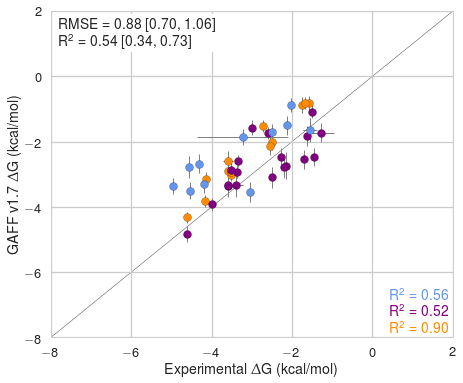

In [158]:
# GAFF v1.7 vs. Experiment

df = bgbg_combined.merge(experimental, on=["System"], suffixes=("_bgbg",
                                                                "_experiment"))
assert(len(df) == 43)

scatter(df, 
        x="Delta G_experiment",
        y="Delta G_bgbg",
        xerr="G_SEM_experiment",
        yerr="G_SEM_bgbg",
        xlabel=r"Experimental $\Delta$G (kcal/mol)",
        ylabel=r"GAFF v1.7 $\Delta$G (kcal/mol)",
        colors=colors,
        name="GAFF-v1.7-vs-Experiment-dG",
        statistics_file_prefix="experimental_bgbg_dG_statistics")

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (56) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (54) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (52) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (65) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (70) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (70) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (105) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (109) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (101) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (55) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (77) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (83) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

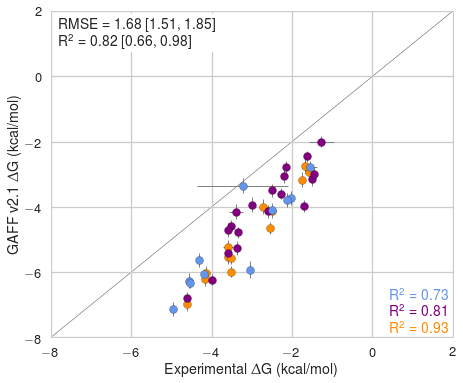

In [159]:
# GAFF v2.1 vs. Experiment

df = bg2bg2_combined.merge(experimental, on=["System"], suffixes=("_bg2bg2",
                                                                "_experiment"))
assert(len(df) == 43)

scatter(df, 
        x="Delta G_experiment",
        y="Delta G_bg2bg2",
        xerr="G_SEM_experiment",
        yerr="G_SEM_bg2bg2",
        xlabel=r"Experimental $\Delta$G (kcal/mol)",
        ylabel=r"GAFF v2.1 $\Delta$G (kcal/mol)",
        colors=colors,
        name="GAFF-v2.1-vs-Experiment-dG",
        statistics_file_prefix="experimental_bg2bg2_dG_statistics")

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (56) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (54) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (52) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (77) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (83) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (69) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (109) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (111) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (108) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/

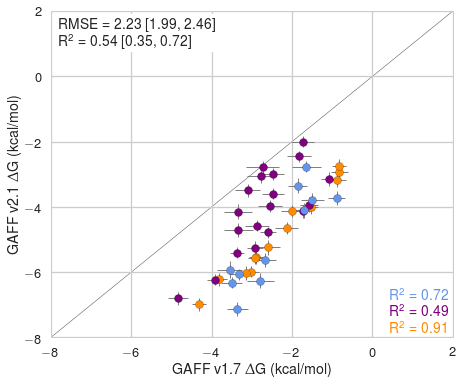

In [160]:
# GAFF v1.7 vs. GAFF v2.1

df = bg2bg2_combined.merge(bgbg_combined, on=["System", "Type"], suffixes=("_bg2bg2",
                                                                "_bgbg"))
assert(len(df) == 43)

scatter(df, 
        x="Delta G_bgbg",
        y="Delta G_bg2bg2",
        xerr="G_SEM_bgbg",
        yerr="G_SEM_bg2bg2",
        xlabel=r"GAFF v1.7 $\Delta$G (kcal/mol)",
        ylabel=r"GAFF v2.1 $\Delta$G (kcal/mol)",
        colors=colors,
        name="GAFF-v2.1-vs-GAFF-v1.7-dG",
        statistics_file_prefix="bgbg_bg2bg2_dG_statistics")

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (56) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (54) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (52) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (78) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (79) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (57) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (40) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (107) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (99) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/ma

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (44) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (93) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))


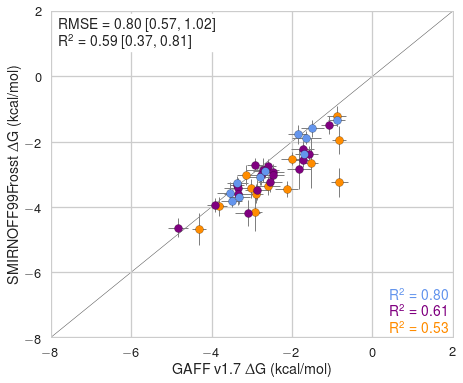

In [161]:
# SMIRNOFF99Frosst vs. GAFF v1.7

df = smirnoff_combined.merge(bgbg_combined, on=["System", "Type"], suffixes=("_smirnoff",
                                                                "_bgbg"))
assert(len(df) == 43)

scatter(df, 
        x="Delta G_bgbg",
        y="Delta G_smirnoff",
        xerr="G_SEM_bgbg",
        yerr="G_SEM_smirnoff",
        xlabel=r"GAFF v1.7 $\Delta$G (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$G (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-GAFF-v1.7-dG",
        statistics_file_prefix="bgbg_smirnoff_dG_statistics")

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (56) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (54) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (52) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (78) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (79) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (57) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (49) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (71) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (40) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (55) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (69) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (91) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

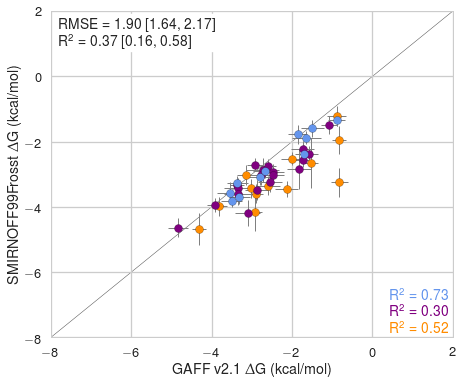

In [162]:
# SMIRNOFF99Frosst vs. GAFF v2.1

df = smirnoff_combined.merge(bgbg_combined, on=["System", "Type"], suffixes=("_smirnoff",
                                                                "_bg2bg2"))
assert(len(df) == 43)

scatter(df, 
        x="Delta G_bg2bg2",
        y="Delta G_smirnoff",
        xerr="G_SEM_bg2bg2",
        yerr="G_SEM_smirnoff",
        xlabel=r"GAFF v2.1 $\Delta$G (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$G (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-GAFF-v2.1-dG",
        statistics_file_prefix="bg2bg2_smirnoff_dG_statistics")